In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
import matplotlib.pyplot as plt
from keras.layers.normalization import BatchNormalization
from keras_preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
cascade_dir = cv2.data.haarcascades
cascade_file = os.path.join(cascade_dir, 'haarcascade_frontalface_default.xml')
if os.path.isfile(cascade_file):
    print("Каскады Хаара найдены:", cascade_file)
else:
    print("Каскады Хаара не были найдены. Загружаю...")
    cv2_base_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/"
    cascade_url = cv2_base_url + 'haarcascade_frontalface_default.xml'
    os.system(f"wget {cascade_url} -P {cascade_dir}")
    print("Каскады Хаара загружены успешно.")
filter_path = cascade_file

Каскады Хаара найдены: /opt/conda/lib/python3.7/site-packages/cv2/data/haarcascade_frontalface_default.xml


In [ ]:
def detect_and_crop_faces(image):
    face_cascade = cv2.CascadeClassifier(filter_path)
    faces = face_cascade.detectMultiScale(image, 1.3, 5)
    cropped_faces = []
    for (x, y, w, h) in faces:
        cropped_faces.append(image[y:y+h, x:x+w])
    return cropped_faces

In [ ]:

dataset_dir = "/kaggle/input/face-recognition-dataset/Original Images/Original Images"
cropped_dataset_dir = "/kaggle/working/CroppedImages"
train_dir = os.path.join(cropped_dataset_dir, "train")
test_dir = os.path.join(cropped_dataset_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
common_size = (128, 128)
for subdir in os.listdir(dataset_dir):
    subdir_path = os.path.join(dataset_dir, subdir)
    if os.path.isdir(subdir_path):
        train_subdir_path = os.path.join(train_dir, subdir)
        test_subdir_path = os.path.join(test_dir, subdir)
        os.makedirs(train_subdir_path, exist_ok=True)
        os.makedirs(test_subdir_path, exist_ok=True)
        image_files = [f for f in os.listdir(subdir_path) if f.endswith('.jpg')]
        for image_name in image_files:
            image_path = os.path.join(subdir_path, image_name)
            img = cv2.imread(image_path)
            faces = detect_and_crop_faces(img)
            for idx, face in enumerate(faces):
                if face is not None:
                    resized_face = cv2.resize(face, common_size)
                    if np.random.rand() < 0.9:  # 90% train, 10% test
                        save_path = os.path.join(train_subdir_path, f"{image_name}_{idx}.jpg")
                    else:
                        save_path = os.path.join(test_subdir_path, f"{image_name}_{idx}.jpg")
                    cv2.imwrite(save_path, resized_face)
print('Лица извлечены, датасет создан')

Лица извлечены, датасет создан


In [ ]:
# Функция для устранения шума с помощью медианного фильтра
def denoise_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Переводим в BGR (OpenCV использует BGR)
    image = cv2.medianBlur(image, 3)  # Применяем медианный фильтр (3x3)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Обратно в RGB
    return image

In [ ]:
# Кастомный генератор с предобработкой изображений
def preprocessing_function(img):
    img = denoise_image(img)  # Убираем шум
    return img / 255.0  # Нормализация

In [ ]:
train_dir = '/kaggle/working/CroppedImages/train'
test_dir = '/kaggle/working/CroppedImages/test'

# Генератор данных с кастомной функцией предобработки
generator = ImageDataGenerator(
    preprocessing_function=preprocessing_function,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

# Загружаем данные и сплитим
train_ds = generator.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    subset="training"  # тренировка
)

val_ds = generator.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    subset="validation"  # валидация
)

# получаем список классов
classes = list(train_ds.class_indices.keys())
print("Classes in training data:", classes)

# Загружаем тестовую выборку
test_ds = generator.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    subset="training"  # This is for test data
)

# получаем список классов на тестовом множестве
test_classes = list(test_ds.class_indices.keys())
print("Classes in test data:", test_classes)

Found 2066 images belonging to 31 classes.
Found 215 images belonging to 31 classes.
Classes in training data: ['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma', 'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron', 'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen', 'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan', 'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow', 'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra', 'Robert Downey Jr', 'Roger Federer', 'Tom Cruise', 'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron']
Found 236 images belonging to 31 classes.
Classes in test data: ['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma', 'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron', 'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen', 'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan', 'Hugh Jackma

Будем тестировать три модели в равных условиях на 20 эпохах с одинаковым размером батча и валидацией

# Простая модель без свертки

In [ ]:
model_simple = Sequential()
model_simple.add(Flatten())
model_simple.add(Dense(128, activation='relu'))
model_simple.add(Dense(256, activation='relu'))
model_simple.add(Dense(1024, activation='relu'))
model_simple.add(Dense(len(classes),activation='softmax'))
model_simple.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ["accuracy"])

In [ ]:
history = model_simple.fit(train_ds, epochs=20, validation_data=val_ds, batch_size=32)

Epoch 1/20
65/65 [==============================] - 9s 138ms/step - loss: 6.6100 - accuracy: 0.0464 - val_loss: 3.4228 - val_accuracy: 0.0419
Epoch 2/20
65/65 [==============================] - 9s 132ms/step - loss: 3.4252 - accuracy: 0.0485 - val_loss: 3.3930 - val_accuracy: 0.0512
Epoch 3/20
65/65 [==============================] - 9s 131ms/step - loss: 3.4077 - accuracy: 0.0485 - val_loss: 3.3879 - val_accuracy: 0.0512
Epoch 4/20
65/65 [==============================] - 9s 133ms/step - loss: 3.4615 - accuracy: 0.0391 - val_loss: 3.3864 - val_accuracy: 0.0512
Epoch 5/20
65/65 [==============================] - 9s 131ms/step - loss: 3.4248 - accuracy: 0.0492 - val_loss: 3.3875 - val_accuracy: 0.0512
Epoch 6/20
65/65 [==============================] - 9s 131ms/step - loss: 3.3785 - accuracy: 0.0553 - val_loss: 3.3875 - val_accuracy: 0.0512
Epoch 7/20
65/65 [==============================] - 9s 133ms/step - loss: 3.3895 - accuracy: 0.0455 - val_loss: 3.3864 - val_accuracy: 0.0512
Epoch 

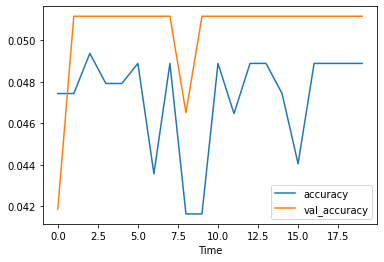

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Time')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

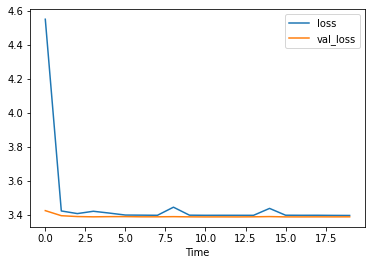

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Time')
plt.legend(['loss', 'val_loss'])
plt.show()

# Модель 2 с простой сверткой

In [ ]:
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(128,128,3)))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(len(classes),activation='softmax'))
model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ["accuracy"])

In [ ]:
history = model_2.fit(train_ds, epochs=20, validation_data=val_ds, batch_size=32)

Epoch 1/20
65/65 [==============================] - 13s 147ms/step - loss: 3.4291 - accuracy: 0.0433 - val_loss: 3.2883 - val_accuracy: 0.0791
Epoch 2/20
65/65 [==============================] - 9s 139ms/step - loss: 3.1562 - accuracy: 0.1194 - val_loss: 2.9089 - val_accuracy: 0.1860
Epoch 3/20
65/65 [==============================] - 9s 139ms/step - loss: 2.6446 - accuracy: 0.2406 - val_loss: 2.5480 - val_accuracy: 0.2651
Epoch 4/20
65/65 [==============================] - 9s 139ms/step - loss: 2.2539 - accuracy: 0.3412 - val_loss: 2.1733 - val_accuracy: 0.4233
Epoch 5/20
65/65 [==============================] - 9s 141ms/step - loss: 1.8548 - accuracy: 0.4482 - val_loss: 2.0075 - val_accuracy: 0.4605
Epoch 6/20
65/65 [==============================] - 9s 138ms/step - loss: 1.5054 - accuracy: 0.5475 - val_loss: 1.8925 - val_accuracy: 0.5070
Epoch 7/20
65/65 [==============================] - 9s 139ms/step - loss: 1.3288 - accuracy: 0.6167 - val_loss: 1.7815 - val_accuracy: 0.5395
Epoch

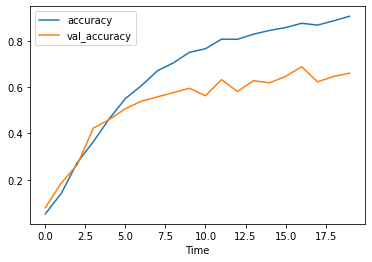

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Time')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

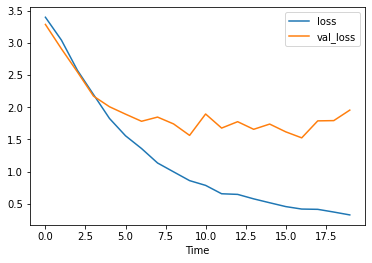

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Time')
plt.legend(['loss', 'val_loss'])
plt.show()

# Модель 3 со сложной сверткой, батч нормализацией и дропаутом

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))  # Повышенный Dropout для улучшения обобщения
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(classes),activation='softmax'))

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 31, 128)      

In [ ]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds, batch_size=32)

Epoch 1/20
65/65 [==============================] - 11s 153ms/step - loss: 3.8777 - accuracy: 0.0374 - val_loss: 3.4295 - val_accuracy: 0.0465
Epoch 2/20
65/65 [==============================] - 9s 144ms/step - loss: 3.4284 - accuracy: 0.0465 - val_loss: 3.4247 - val_accuracy: 0.0465
Epoch 3/20
65/65 [==============================] - 9s 142ms/step - loss: 3.4261 - accuracy: 0.0427 - val_loss: 3.4205 - val_accuracy: 0.0512
Epoch 4/20
65/65 [==============================] - 9s 140ms/step - loss: 3.4201 - accuracy: 0.0568 - val_loss: 3.4166 - val_accuracy: 0.0512
Epoch 5/20
65/65 [==============================] - 9s 142ms/step - loss: 3.4187 - accuracy: 0.0490 - val_loss: 3.4134 - val_accuracy: 0.0512
Epoch 6/20
65/65 [==============================] - 9s 143ms/step - loss: 3.4131 - accuracy: 0.0428 - val_loss: 3.4103 - val_accuracy: 0.0512
Epoch 7/20
65/65 [==============================] - 9s 142ms/step - loss: 3.4137 - accuracy: 0.0472 - val_loss: 3.4077 - val_accuracy: 0.0512
Epoch

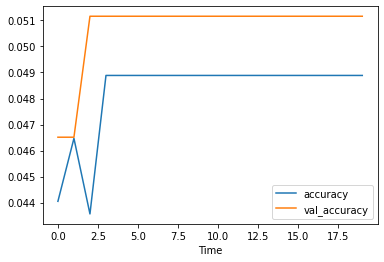

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Time')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

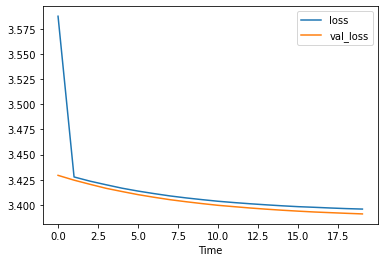

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Time')
plt.legend(['loss', 'val_loss'])
plt.show()

Вывод - как ни странно, более сложная модель показала более худший результат, выбираем модель 2 для дальнейшего дообучения.

# Дообучение лучшей модели до 100 эпох

In [ ]:
history = model_2.fit(train_ds, epochs=80, validation_data=val_ds, batch_size=32)

Epoch 1/80
65/65 [==============================] - 9s 144ms/step - loss: 0.3171 - accuracy: 0.9013 - val_loss: 2.0733 - val_accuracy: 0.6512
Epoch 2/80
65/65 [==============================] - 9s 136ms/step - loss: 0.2984 - accuracy: 0.9095 - val_loss: 1.7690 - val_accuracy: 0.6930
Epoch 3/80
65/65 [==============================] - 9s 137ms/step - loss: 0.2790 - accuracy: 0.9158 - val_loss: 2.1634 - val_accuracy: 0.6326
Epoch 4/80
65/65 [==============================] - 9s 138ms/step - loss: 0.2608 - accuracy: 0.9158 - val_loss: 1.7834 - val_accuracy: 0.6419
Epoch 5/80
65/65 [==============================] - 9s 139ms/step - loss: 0.2490 - accuracy: 0.9293 - val_loss: 1.8829 - val_accuracy: 0.6651
Epoch 6/80
65/65 [==============================] - 9s 138ms/step - loss: 0.2089 - accuracy: 0.9298 - val_loss: 1.9175 - val_accuracy: 0.6651
Epoch 7/80
65/65 [==============================] - 9s 137ms/step - loss: 0.2261 - accuracy: 0.9332 - val_loss: 1.9625 - val_accuracy: 0.6419
Epoch 

KeyboardInterrupt: 

Вручную остановили процесс обучения, так как всё остановилось примерном на одном уровне

In [ ]:
train_loss, train_accuracy = model_2.evaluate(train_ds)
print(f"Training Accuracy: {train_accuracy*100: .2f}")

65/65 [==============================] - 8s 122ms/step - loss: 0.1142 - accuracy: 0.9637
Training Accuracy:  96.37


In [ ]:
test_loss, test_accuracy = model_2.evaluate(val_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

7/7 [==============================] - 1s 115ms/step - loss: 2.4568 - accuracy: 0.6744
Test Accuracy: 67.44%


In [ ]:
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(128,128,3))
    plt.imshow(img)
    plt.show()
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    pred = model_2.predict(images, batch_size=32)
    print("Actual: "+(image_path.split("/")[-1]).split("_")[0])
    print("Predicted: "+classes[np.argmax(pred)])

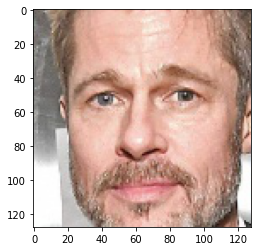

Actual: Brad Pitt
Predicted: Brad Pitt


In [ ]:
predict_image("/kaggle/working/CroppedImages/test/Brad Pitt/Brad Pitt_71.jpg_0.jpg")

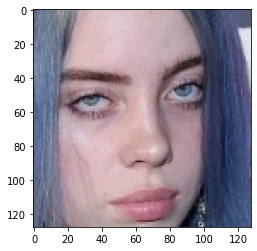

Actual: Billie Eilish
Predicted: Billie Eilish


In [ ]:
predict_image("/kaggle/working/CroppedImages/test/Billie Eilish/Billie Eilish_44.jpg_0.jpg")

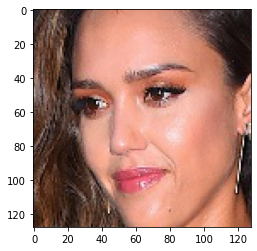

Actual: Jessica Alba
Predicted: Jessica Alba


In [ ]:
predict_image("/kaggle/working/CroppedImages/test/Jessica Alba/Jessica Alba_15.jpg_0.jpg")

In [ ]:
model_2.save('FRM.h5')

In [ ]:
print(classes)

['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma', 'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron', 'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen', 'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan', 'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow', 'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra', 'Robert Downey Jr', 'Roger Federer', 'Tom Cruise', 'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron']


In [ ]:
import pickle

# Сохраняем классы в файл
with open("classes.pkl", "wb") as f:
    pickle.dump(classes, f)